In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [4]:
A,D = 1.0,1.0
delta_t_list=np.linspace(0.01,2,20)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [5]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

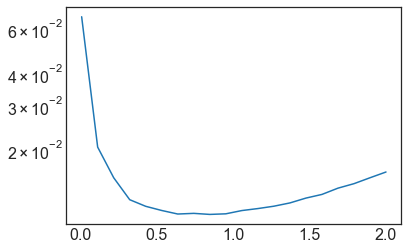

In [6]:
plt.semilogy(delta_t_list,result_Bayes_array.T[3])

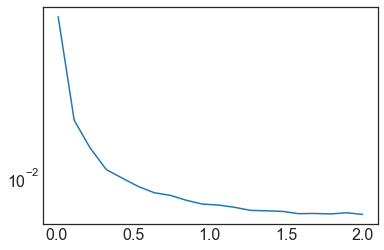

In [7]:
plt.semilogy(delta_t_list,result_Bayes_array.T[1])

In [39]:
A,D = 1.0,1.0
delta_t_list=np.linspace(0.01,2,200)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = 7
print(delta_t_list[pick_delta])
data = langevin.time_series(A=A, D=D, delta_t=delta_t_list[pick_delta], N=N)

0.08


In [38]:
# compile model for reuse
sm = lcm.OU_DA()
sm.samples=5000

In [25]:
trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t_list[pick_delta],
                N=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:26<00:00, 415.04draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1ef38710>,
      dtype=object)

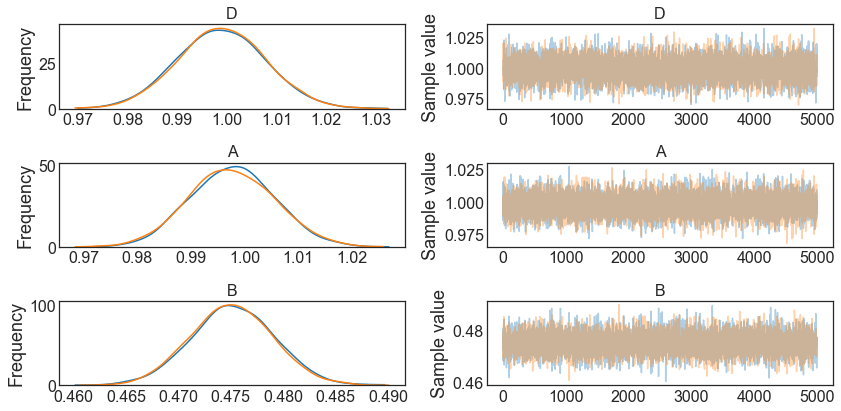

In [26]:
pm.traceplot(trace)

In [40]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t,
                N=50000)
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 463.48draws/s]


0.02


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 486.19draws/s]


0.03


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 519.16draws/s]


0.04


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 510.57draws/s]


0.05


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 512.25draws/s]


0.060000000000000005


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 503.91draws/s]


0.06999999999999999


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 466.93draws/s]
The acceptance probability does not match the target. It is 0.8808115060394154, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856027827822399, but should be close to 0.8. Try to increase the number of tuning steps.


0.08


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 502.84draws/s]
The acceptance probability does not match the target. It is 0.8802327870922039, but should be close to 0.8. Try to increase the number of tuning steps.


0.09


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 494.30draws/s]
The acceptance probability does not match the target. It is 0.8859136605148592, but should be close to 0.8. Try to increase the number of tuning steps.


0.09999999999999999


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 492.48draws/s]


0.11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 493.23draws/s]
The acceptance probability does not match the target. It is 0.8840261936991209, but should be close to 0.8. Try to increase the number of tuning steps.


0.12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 468.69draws/s]
The acceptance probability does not match the target. It is 0.8810335193319195, but should be close to 0.8. Try to increase the number of tuning steps.


0.13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 473.85draws/s]


0.14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:24<00:00, 454.52draws/s]
The acceptance probability does not match the target. It is 0.8849311324747842, but should be close to 0.8. Try to increase the number of tuning steps.


0.15000000000000002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 467.35draws/s]
The acceptance probability does not match the target. It is 0.8866876264330972, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797127441887024, but should be close to 0.8. Try to increase the number of tuning steps.


0.16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 475.47draws/s]


0.17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 478.06draws/s]
The acceptance probability does not match the target. It is 0.8796733080793214, but should be close to 0.8. Try to increase the number of tuning steps.


0.18000000000000002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 460.45draws/s]
The acceptance probability does not match the target. It is 0.8811795364260291, but should be close to 0.8. Try to increase the number of tuning steps.


0.19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 473.71draws/s]


0.2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:24<00:00, 449.13draws/s]
The acceptance probability does not match the target. It is 0.8885192403199826, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822418908119297, but should be close to 0.8. Try to increase the number of tuning steps.


0.21000000000000002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:39<00:00, 276.98draws/s]
The acceptance probability does not match the target. It is 0.9287443116304662, but should be close to 0.8. Try to increase the number of tuning steps.


0.22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 475.43draws/s]
The acceptance probability does not match the target. It is 0.88124133414165, but should be close to 0.8. Try to increase the number of tuning steps.


0.23


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 484.75draws/s]


0.24000000000000002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 492.46draws/s]


0.25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 471.46draws/s]
The acceptance probability does not match the target. It is 0.8865595928582672, but should be close to 0.8. Try to increase the number of tuning steps.


0.26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 488.43draws/s]


0.27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 486.03draws/s]
The acceptance probability does not match the target. It is 0.8884935674731811, but should be close to 0.8. Try to increase the number of tuning steps.


0.28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 500.66draws/s]
The acceptance probability does not match the target. It is 0.8875796509924416, but should be close to 0.8. Try to increase the number of tuning steps.


0.29000000000000004


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:24<00:00, 457.53draws/s]
The acceptance probability does not match the target. It is 0.8823047965276567, but should be close to 0.8. Try to increase the number of tuning steps.


0.3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 490.11draws/s]
The acceptance probability does not match the target. It is 0.8874134572978528, but should be close to 0.8. Try to increase the number of tuning steps.


0.31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 501.81draws/s]


0.32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 461.95draws/s]
The acceptance probability does not match the target. It is 0.8991468669438475, but should be close to 0.8. Try to increase the number of tuning steps.


0.33


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 490.19draws/s]
The acceptance probability does not match the target. It is 0.8827956673664972, but should be close to 0.8. Try to increase the number of tuning steps.


0.34


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 481.26draws/s]
The acceptance probability does not match the target. It is 0.885103035667141, but should be close to 0.8. Try to increase the number of tuning steps.


0.35000000000000003


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 495.40draws/s]


0.36000000000000004


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 497.04draws/s]


0.37


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 463.89draws/s]
The acceptance probability does not match the target. It is 0.8800497430425726, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845273650378409, but should be close to 0.8. Try to increase the number of tuning steps.


0.38


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 490.58draws/s]
The acceptance probability does not match the target. It is 0.8811612264879973, but should be close to 0.8. Try to increase the number of tuning steps.


0.39


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 497.16draws/s]


0.4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 490.16draws/s]
The acceptance probability does not match the target. It is 0.8793608717114934, but should be close to 0.8. Try to increase the number of tuning steps.


0.41000000000000003


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 486.61draws/s]
The acceptance probability does not match the target. It is 0.8793172902134789, but should be close to 0.8. Try to increase the number of tuning steps.


0.42000000000000004


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 488.05draws/s]


0.43


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 482.97draws/s]
The acceptance probability does not match the target. It is 0.8809428343919679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8834018670552524, but should be close to 0.8. Try to increase the number of tuning steps.


0.44


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 482.47draws/s]
The acceptance probability does not match the target. It is 0.8854753872274167, but should be close to 0.8. Try to increase the number of tuning steps.


0.45


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 470.70draws/s]
The acceptance probability does not match the target. It is 0.8807000911950053, but should be close to 0.8. Try to increase the number of tuning steps.


0.46


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:24<00:00, 457.74draws/s]


0.47000000000000003


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 468.11draws/s]
The acceptance probability does not match the target. It is 0.8807022696329965, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822822140941088, but should be close to 0.8. Try to increase the number of tuning steps.


0.48000000000000004


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 515.53draws/s]
The acceptance probability does not match the target. It is 0.8844985343739913, but should be close to 0.8. Try to increase the number of tuning steps.


0.49


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 549.14draws/s]


0.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 556.80draws/s]
The acceptance probability does not match the target. It is 0.8799778517139648, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880460956521183, but should be close to 0.8. Try to increase the number of tuning steps.


0.51


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 570.41draws/s]


0.52


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 558.75draws/s]
The acceptance probability does not match the target. It is 0.8805029425337825, but should be close to 0.8. Try to increase the number of tuning steps.


0.53


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 553.21draws/s]
The acceptance probability does not match the target. It is 0.882512374370421, but should be close to 0.8. Try to increase the number of tuning steps.


0.54


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 570.57draws/s]


0.55


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 564.59draws/s]


0.56


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 547.81draws/s]


0.5700000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 569.22draws/s]


0.5800000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 575.72draws/s]


0.59


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 540.92draws/s]
The acceptance probability does not match the target. It is 0.882219107685048, but should be close to 0.8. Try to increase the number of tuning steps.


0.6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 578.55draws/s]


0.61


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 568.67draws/s]


0.62


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 531.72draws/s]
The acceptance probability does not match the target. It is 0.8823306468938914, but should be close to 0.8. Try to increase the number of tuning steps.


0.63


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 557.37draws/s]


0.64


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 518.15draws/s]
The acceptance probability does not match the target. It is 0.8848587760357304, but should be close to 0.8. Try to increase the number of tuning steps.


0.65


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 567.66draws/s]


0.66


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 558.98draws/s]
The acceptance probability does not match the target. It is 0.8790716996216584, but should be close to 0.8. Try to increase the number of tuning steps.


0.67


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 551.79draws/s]
The acceptance probability does not match the target. It is 0.884768638327995, but should be close to 0.8. Try to increase the number of tuning steps.


0.68


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 567.65draws/s]


0.6900000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 546.49draws/s]
The acceptance probability does not match the target. It is 0.8834456782213814, but should be close to 0.8. Try to increase the number of tuning steps.


0.7000000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 527.68draws/s]
The acceptance probability does not match the target. It is 0.8849175060870046, but should be close to 0.8. Try to increase the number of tuning steps.


0.7100000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 549.23draws/s]
The acceptance probability does not match the target. It is 0.8885789658863514, but should be close to 0.8. Try to increase the number of tuning steps.


0.72


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 550.72draws/s]
The acceptance probability does not match the target. It is 0.8881942091548719, but should be close to 0.8. Try to increase the number of tuning steps.


0.73


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 523.22draws/s]
The acceptance probability does not match the target. It is 0.8894071746922572, but should be close to 0.8. Try to increase the number of tuning steps.


0.74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:18<00:00, 580.73draws/s]


0.75


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 554.40draws/s]


0.76


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 552.12draws/s]


0.77


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 553.62draws/s]
The acceptance probability does not match the target. It is 0.882866424117814, but should be close to 0.8. Try to increase the number of tuning steps.


0.78


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 557.27draws/s]


0.79


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 573.38draws/s]


0.8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 530.49draws/s]
The acceptance probability does not match the target. It is 0.8803999047561917, but should be close to 0.8. Try to increase the number of tuning steps.


0.81


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 521.54draws/s]
The acceptance probability does not match the target. It is 0.8994429777064972, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8786499998624467, but should be close to 0.8. Try to increase the number of tuning steps.


0.8200000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 551.79draws/s]


0.8300000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 548.03draws/s]
The acceptance probability does not match the target. It is 0.8788293980521732, but should be close to 0.8. Try to increase the number of tuning steps.


0.8400000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 544.97draws/s]


0.85


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 554.21draws/s]


0.86


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 554.88draws/s]


0.87


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 509.28draws/s]
The acceptance probability does not match the target. It is 0.9030069283643674, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856132522124625, but should be close to 0.8. Try to increase the number of tuning steps.


0.88


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 532.81draws/s]
The acceptance probability does not match the target. It is 0.8895619151298942, but should be close to 0.8. Try to increase the number of tuning steps.


0.89


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 553.23draws/s]
The acceptance probability does not match the target. It is 0.8818965644945881, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827209240562001, but should be close to 0.8. Try to increase the number of tuning steps.


0.9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 387.48draws/s]


0.91


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:18<00:00, 579.40draws/s]


0.92


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 536.59draws/s]
The acceptance probability does not match the target. It is 0.8823812363351143, but should be close to 0.8. Try to increase the number of tuning steps.


0.93


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 521.77draws/s]
The acceptance probability does not match the target. It is 0.8991090500230228, but should be close to 0.8. Try to increase the number of tuning steps.


0.9400000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 527.06draws/s]
The acceptance probability does not match the target. It is 0.8911794565777624, but should be close to 0.8. Try to increase the number of tuning steps.


0.9500000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 510.44draws/s]
The acceptance probability does not match the target. It is 0.8800635790992936, but should be close to 0.8. Try to increase the number of tuning steps.


0.9600000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 554.17draws/s]


0.97


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 523.67draws/s]
The acceptance probability does not match the target. It is 0.8902540935596474, but should be close to 0.8. Try to increase the number of tuning steps.


0.98


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 530.32draws/s]
The acceptance probability does not match the target. It is 0.8893423551783017, but should be close to 0.8. Try to increase the number of tuning steps.


0.99


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 524.68draws/s]
The acceptance probability does not match the target. It is 0.8930979825088521, but should be close to 0.8. Try to increase the number of tuning steps.


1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 560.17draws/s]


1.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 526.19draws/s]
The acceptance probability does not match the target. It is 0.8835814835715461, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800310065375462, but should be close to 0.8. Try to increase the number of tuning steps.


1.02


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 540.56draws/s]
The acceptance probability does not match the target. It is 0.8839483381697557, but should be close to 0.8. Try to increase the number of tuning steps.


1.03


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 477.86draws/s]
The acceptance probability does not match the target. It is 0.9036109551261836, but should be close to 0.8. Try to increase the number of tuning steps.


1.04


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 535.93draws/s]


1.05


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 513.01draws/s]
The acceptance probability does not match the target. It is 0.8878069371256467, but should be close to 0.8. Try to increase the number of tuning steps.


1.06


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 534.51draws/s]


1.07


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 537.98draws/s]
The acceptance probability does not match the target. It is 0.8796680889848142, but should be close to 0.8. Try to increase the number of tuning steps.


1.08


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 550.02draws/s]


1.09


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 506.99draws/s]
The acceptance probability does not match the target. It is 0.8940182864014181, but should be close to 0.8. Try to increase the number of tuning steps.


1.1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 534.77draws/s]
The acceptance probability does not match the target. It is 0.8821456696334197, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838761504720132, but should be close to 0.8. Try to increase the number of tuning steps.


1.11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 530.08draws/s]
The acceptance probability does not match the target. It is 0.8840675655570135, but should be close to 0.8. Try to increase the number of tuning steps.


1.12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 546.92draws/s]


1.1300000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 573.49draws/s]


1.1400000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 516.53draws/s]
The acceptance probability does not match the target. It is 0.8885039134864194, but should be close to 0.8. Try to increase the number of tuning steps.


1.1500000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 530.12draws/s]
The acceptance probability does not match the target. It is 0.8796322624210863, but should be close to 0.8. Try to increase the number of tuning steps.


1.1600000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 496.96draws/s]
The acceptance probability does not match the target. It is 0.8827434969519953, but should be close to 0.8. Try to increase the number of tuning steps.


1.17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 513.67draws/s]
The acceptance probability does not match the target. It is 0.894054940194668, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883029304400726, but should be close to 0.8. Try to increase the number of tuning steps.


1.18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 520.74draws/s]


1.19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 458.58draws/s]
The acceptance probability does not match the target. It is 0.9047144619066722, but should be close to 0.8. Try to increase the number of tuning steps.


1.2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 557.15draws/s]


1.21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 510.12draws/s]
The acceptance probability does not match the target. It is 0.8973627517762005, but should be close to 0.8. Try to increase the number of tuning steps.


1.22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 535.45draws/s]
The acceptance probability does not match the target. It is 0.8799624007918468, but should be close to 0.8. Try to increase the number of tuning steps.


1.23


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 519.23draws/s]
The acceptance probability does not match the target. It is 0.8824555675583193, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845693684032174, but should be close to 0.8. Try to increase the number of tuning steps.


1.24


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 322.23draws/s]
The acceptance probability does not match the target. It is 0.8837387539780391, but should be close to 0.8. Try to increase the number of tuning steps.


1.25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 554.50draws/s]


1.26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 489.49draws/s]
The acceptance probability does not match the target. It is 0.8828877546016707, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8997425365543493, but should be close to 0.8. Try to increase the number of tuning steps.


1.27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 548.06draws/s]


1.28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 497.36draws/s]
The acceptance probability does not match the target. It is 0.8979510120984245, but should be close to 0.8. Try to increase the number of tuning steps.


1.29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 485.82draws/s]
The acceptance probability does not match the target. It is 0.8883045647880914, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8964706121097661, but should be close to 0.8. Try to increase the number of tuning steps.


1.3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 512.46draws/s]


1.31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 521.01draws/s]
The acceptance probability does not match the target. It is 0.87920872306393, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886689125110425, but should be close to 0.8. Try to increase the number of tuning steps.


1.32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 560.23draws/s]


1.33


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 532.36draws/s]


1.34


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 526.05draws/s]


1.35


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 527.20draws/s]
The acceptance probability does not match the target. It is 0.8815339789391601, but should be close to 0.8. Try to increase the number of tuning steps.


1.36


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 550.35draws/s]


1.37


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 546.47draws/s]


1.3800000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 521.46draws/s]


1.3900000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 519.30draws/s]
The acceptance probability does not match the target. It is 0.8805710460967461, but should be close to 0.8. Try to increase the number of tuning steps.


1.4000000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 540.70draws/s]


1.4100000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 515.67draws/s]
The acceptance probability does not match the target. It is 0.884539880286036, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867989017175789, but should be close to 0.8. Try to increase the number of tuning steps.


1.42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 517.85draws/s]
The acceptance probability does not match the target. It is 0.8841087485237048, but should be close to 0.8. Try to increase the number of tuning steps.


1.43


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 461.85draws/s]
The acceptance probability does not match the target. It is 0.889136254139108, but should be close to 0.8. Try to increase the number of tuning steps.


1.44


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 525.08draws/s]
The acceptance probability does not match the target. It is 0.8839759532907396, but should be close to 0.8. Try to increase the number of tuning steps.


1.45


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 476.80draws/s]
The acceptance probability does not match the target. It is 0.9023937183527263, but should be close to 0.8. Try to increase the number of tuning steps.


1.46


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:26<00:00, 408.11draws/s]
The acceptance probability does not match the target. It is 0.9381457120137064, but should be close to 0.8. Try to increase the number of tuning steps.


1.47


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 543.47draws/s]


1.48


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 516.01draws/s]


1.49


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 501.47draws/s]
The acceptance probability does not match the target. It is 0.8893670189144602, but should be close to 0.8. Try to increase the number of tuning steps.


1.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 518.18draws/s]
The acceptance probability does not match the target. It is 0.888727165867323, but should be close to 0.8. Try to increase the number of tuning steps.


1.51


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 523.27draws/s]


1.52


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 512.97draws/s]
The acceptance probability does not match the target. It is 0.8797401690359763, but should be close to 0.8. Try to increase the number of tuning steps.


1.53


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 515.89draws/s]
The acceptance probability does not match the target. It is 0.8862407271063507, but should be close to 0.8. Try to increase the number of tuning steps.


1.54


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 533.86draws/s]


1.55


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 521.17draws/s]


1.56


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:24<00:00, 455.92draws/s]
The acceptance probability does not match the target. It is 0.9052254807210296, but should be close to 0.8. Try to increase the number of tuning steps.


1.57


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 540.45draws/s]


1.58


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 533.79draws/s]
The acceptance probability does not match the target. It is 0.8791319169386896, but should be close to 0.8. Try to increase the number of tuning steps.


1.59


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:24<00:00, 447.34draws/s]
The acceptance probability does not match the target. It is 0.9031688899614135, but should be close to 0.8. Try to increase the number of tuning steps.


1.6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 521.38draws/s]


1.61


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 525.43draws/s]
The acceptance probability does not match the target. It is 0.8795376483996801, but should be close to 0.8. Try to increase the number of tuning steps.


1.62


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 538.00draws/s]


1.6300000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 487.68draws/s]
The acceptance probability does not match the target. It is 0.8852180423859506, but should be close to 0.8. Try to increase the number of tuning steps.


1.6400000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 534.29draws/s]


1.6500000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 502.72draws/s]
The acceptance probability does not match the target. It is 0.8906298564963258, but should be close to 0.8. Try to increase the number of tuning steps.


1.6600000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 410.80draws/s]


1.6700000000000002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 520.78draws/s]
The acceptance probability does not match the target. It is 0.8836956632472552, but should be close to 0.8. Try to increase the number of tuning steps.


1.68


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 542.90draws/s]


1.69


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 537.82draws/s]


1.7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 521.46draws/s]


1.71


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 529.29draws/s]


1.72


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 509.27draws/s]
The acceptance probability does not match the target. It is 0.8886678163731903, but should be close to 0.8. Try to increase the number of tuning steps.


1.73


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 553.96draws/s]


1.74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:25<00:00, 290.67draws/s]
The acceptance probability does not match the target. It is 0.9119668751953988, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842065335297518, but should be close to 0.8. Try to increase the number of tuning steps.


1.75


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 527.72draws/s]
The acceptance probability does not match the target. It is 0.8865828800233967, but should be close to 0.8. Try to increase the number of tuning steps.


1.76


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 462.02draws/s]
The acceptance probability does not match the target. It is 0.8928321544306027, but should be close to 0.8. Try to increase the number of tuning steps.


1.77


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:27<00:00, 400.92draws/s]
The acceptance probability does not match the target. It is 0.9324306165631092, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8814941145473413, but should be close to 0.8. Try to increase the number of tuning steps.


1.78


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 506.81draws/s]
The acceptance probability does not match the target. It is 0.8901034332816891, but should be close to 0.8. Try to increase the number of tuning steps.


1.79


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 510.52draws/s]
The acceptance probability does not match the target. It is 0.8911921990605374, but should be close to 0.8. Try to increase the number of tuning steps.


1.8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 521.15draws/s]


1.81


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 554.45draws/s]


1.82


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 525.29draws/s]


1.83


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 530.63draws/s]


1.84


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 518.57draws/s]
The acceptance probability does not match the target. It is 0.8873424027301768, but should be close to 0.8. Try to increase the number of tuning steps.


1.85


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 374.42draws/s]
The acceptance probability does not match the target. It is 0.8805102219694282, but should be close to 0.8. Try to increase the number of tuning steps.


1.86


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 524.93draws/s]


1.87


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 539.11draws/s]


1.8800000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 507.72draws/s]
The acceptance probability does not match the target. It is 0.8868338801595381, but should be close to 0.8. Try to increase the number of tuning steps.


1.8900000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 323.05draws/s]
The acceptance probability does not match the target. It is 0.8925465409858191, but should be close to 0.8. Try to increase the number of tuning steps.


1.9000000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 530.40draws/s]
The acceptance probability does not match the target. It is 0.8789139173946403, but should be close to 0.8. Try to increase the number of tuning steps.


1.9100000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 484.91draws/s]
The acceptance probability does not match the target. It is 0.887777804166105, but should be close to 0.8. Try to increase the number of tuning steps.


1.9200000000000002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 524.02draws/s]
The acceptance probability does not match the target. It is 0.888326019354916, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856505947274326, but should be close to 0.8. Try to increase the number of tuning steps.


1.93


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 524.66draws/s]


1.94


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 522.07draws/s]
The acceptance probability does not match the target. It is 0.8798899133524394, but should be close to 0.8. Try to increase the number of tuning steps.


1.95


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 562.83draws/s]


1.96


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 537.71draws/s]
The acceptance probability does not match the target. It is 0.878891426055809, but should be close to 0.8. Try to increase the number of tuning steps.


1.97


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:22<00:00, 498.87draws/s]
The acceptance probability does not match the target. It is 0.8874350999249542, but should be close to 0.8. Try to increase the number of tuning steps.


1.98


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 510.04draws/s]
The acceptance probability does not match the target. It is 0.887182942831271, but should be close to 0.8. Try to increase the number of tuning steps.


1.99


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 504.96draws/s]
The acceptance probability does not match the target. It is 0.8990363240594214, but should be close to 0.8. Try to increase the number of tuning steps.


2.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:21<00:00, 513.82draws/s]
The acceptance probability does not match the target. It is 0.8811405704013094, but should be close to 0.8. Try to increase the number of tuning steps.


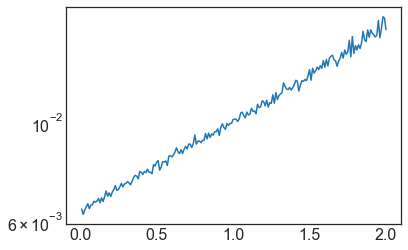

In [41]:
plt.semilogy(delta_t_list,result_array.T[3])

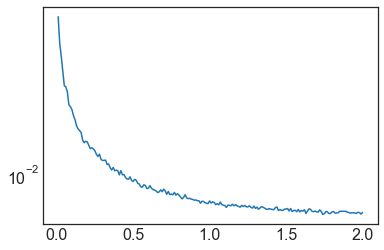

In [42]:
plt.semilogy(delta_t_list,result_array.T[1])

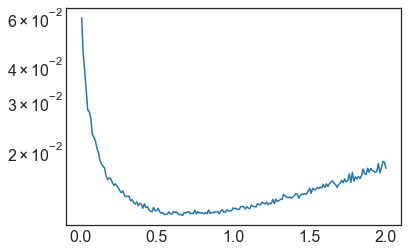

In [43]:
dtau = np.sqrt(result_array.T[1]**2+result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau)